### Fetching the data

In [71]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH  = "datasets/housing"
HOUSING_URL   = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "/housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

#### Load data by pandas

In [72]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#### Quick look at the data structure

In [73]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


There are 10 attributes (longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_housing_value, ocean_promixity)

In [74]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20640 samples, fairly small by ML standards. Notice that the total_bedrooms attribute has only 20433 non-null values, meaning that 207 districts are missing this feature.

All attributes are numerical, except the ocean_proximity field, it is categorical attribute. We can figure out how many categories exists and how many district belong to each category by using <i>value_counts</i> method.

In [75]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [76]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


[]

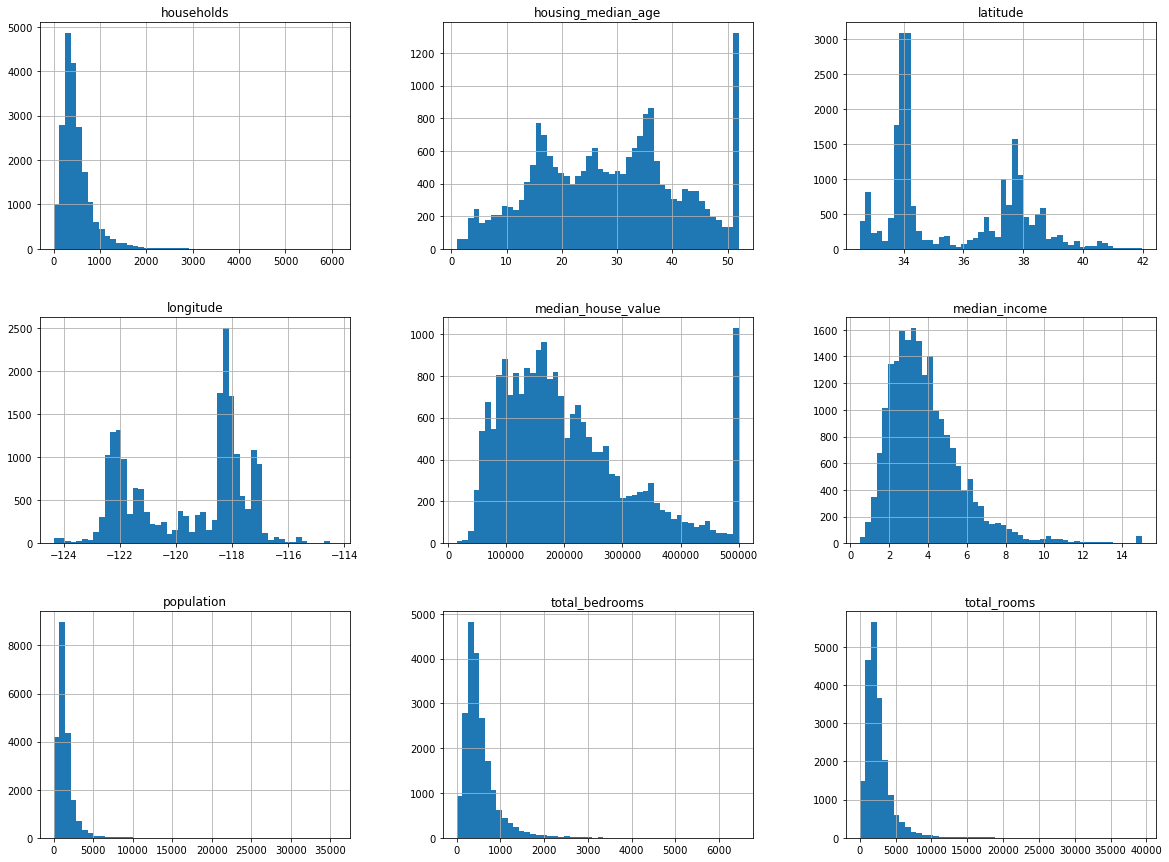

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.plot()

#### Notice a few things in these histograms:

1. The median_income attribute does not look like it is expressed in US Dollars. The data had been scaled and capped at 15 for higher median incomes and at 0.5 for lower median incomes.

2. The housing median age and median house value were also capped. The latter may be a serious problem since it is your target attribute. If client require that they need precise prediction even beyond $500000, then you have 2 options:
    
    a. Collect proper labels for the districts whose labels were capped.
    
    b. Remove those districts from the training set and also on test set.
3. These attributes have very different scales.
4. Many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some ML algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shape distribution.


## Create a test set

Create a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside.

In [78]:
import numpy as np


def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), " train + ", len(test_set), " test")

16512  train +  4128  test


#### Explain
Well, this work. But it is not perfect: if you run the program again, it will generate a different test set and you will get to see the whole dataset. 

One solution is save test set on the first run and the load it in subsequent run. Another option is set the random number generator's seed before calling numpy.random.permutation, so that it always generates the same shuffled samples.

Both the solutions will break next time you fetch an update dataset. A common solution is to use each instance's identifier to decide whether or not it should go in the test set. For example, you could compute a hash of each of each instance's identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 ( ~ 20% of 256). This ensures that the test set will remain consistent across multiple runs, even if you refresh dataset.

In [79]:
import hashlib


def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()      # add an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

#### Explain
Scikit-learn provides a few functions to split dataset into multiple subset in various way. The simplest function is train_test_split which does pretty much the same thing as the function split_train_test defined earlier, with couple additional parameters: random seed, pass multiple dataset same rows.

In [80]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered purely random sampling method. This is generally fine if your dataset is large enough, but if it is not, you run the risk of introducing a significant sampling bias.

Suppose the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories incomes in the whole dataset. Since the median income is continuous attribute, you first need to create an income category attribute.

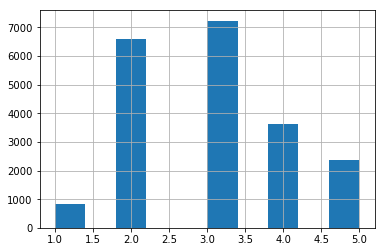

In [82]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5.0, 5.0, inplace = True)
housing["income_cat"].hist()
plt.show()

Now we are aready to do stratified sampling based on the income category. 

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]
    
housing["income_cat"].value_counts() / len(housing)
                                           

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [84]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [85]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set["income_cat"].value_counts() / len(test_set)

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

In [86]:
# Remove incomet_cat
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Visualize the data

In [87]:
# Set test set aside and explose training set
housing = strat_train_set.copy()

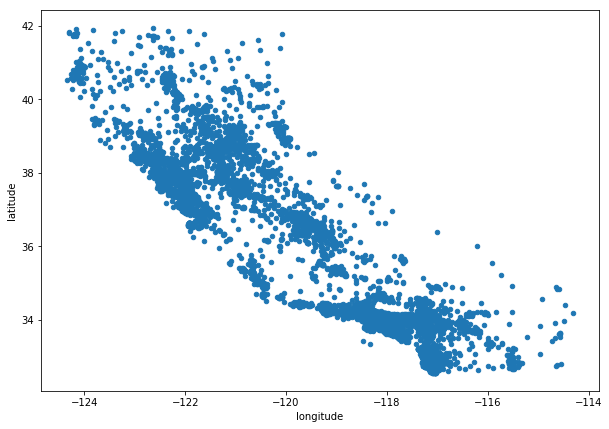

In [88]:
# Visualize geographical data
housing.plot(kind='scatter', x= "longitude", y = "latitude", figsize=(10,7))

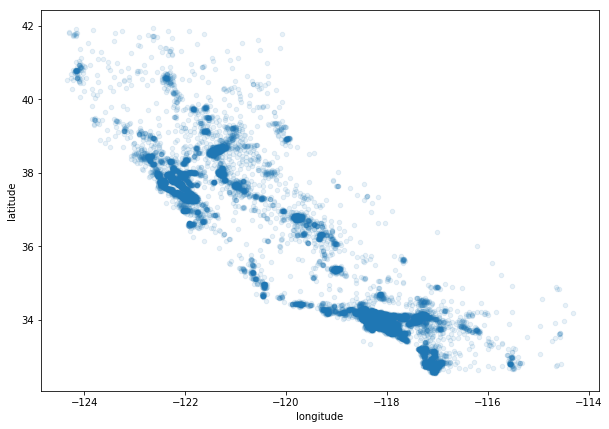

In [89]:
# make more visual with set alpha = 0.1
housing.plot(kind='scatter', x="longitude", y="latitude", alpha = 0.1, figsize=(10,7))

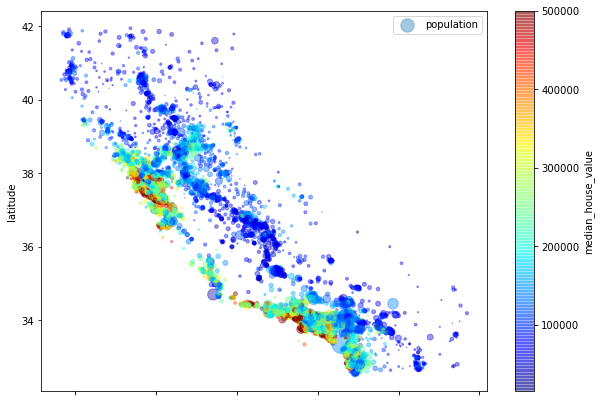

In [90]:
# more visual with color by price, radius circle by population
housing.plot(kind='scatter', x="longitude", y ="latitude", alpha=0.4, s=housing["population"]/100, figsize=(10,7),
             label="population", c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

This plot show that the housing prices are very much related to the location (e.g. close to the ocean) and to the population density.

### Looking for correlations

In [91]:
corr_matrix= housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=True)

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

When it is close to 1, it means that there is a strong positive correlation; for example median house value tends to go up when median income go up. When the correlation close to -1, it is that there is a strong negative correlation. Finally when cofficients close to zero mean that there is no linear correlation.

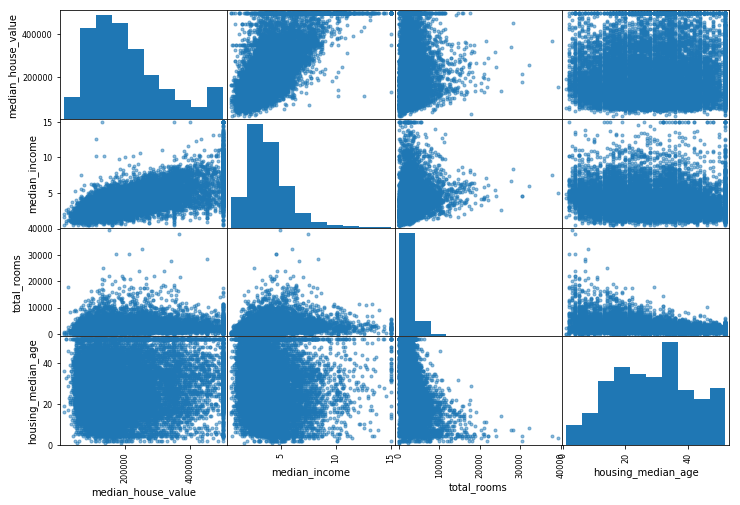

In [92]:
# show correlation between attributes (only with median housing value)
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

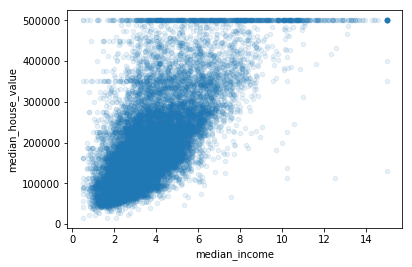

In [93]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

This plot reveals somethings. First, the correlation is indeed very strong; you can clearly see the upward trend and the points is not too despered. Second, the price cap that we notice earlier is clearly visible as a horizontal line at 500000. But this plot reveals other less obvious straight lines: a horizontal line around 450000, 350000, 280000 and a few more below that. You may want to try removing the corresponding district to prevent your algorithms from learning to reproduce these data quirks.

### Experiment with attribute combinations

For example, the total number of rooms in a district is not very useful if you don't know how many household there are. What you really want to know is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seem like an interesting combination to look at

In [94]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [95]:
# covariance
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=True)

bedrooms_per_room          -0.259984
latitude                   -0.142724
longitude                  -0.047432
population                 -0.026920
population_per_household   -0.021985
total_bedrooms              0.047689
households                  0.064506
housing_median_age          0.114110
total_rooms                 0.135097
rooms_per_household         0.146285
median_income               0.687160
median_house_value          1.000000
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total_rooms or bed_rooms. 

The number of room per household is more informative than total rooms in a district



### Prepare the data for machine learning algorithm

In [96]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

Most ML algorithms cannot work with missing features. The feature total_bedrooms has some missing values, so there are 3 options:  
    * Get rid of the corresponding districts  
    * Ged rid of the whole attribute  
    * Set the values to some values (zeros, mean, median, ...)  
  


In [97]:
# housing.dropna(subset=["total_bedrooms"]) # options 1
# housing.drop("total_bedrooms", axis=1)    # options 2
# median = housing["total_bedrooms"].median()  # option 3
# housing["total_bedrooms"].findna(median)     

If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

In [98]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = "median")
# imputer cannot work with non-numerical features
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

imputer.statistics_

In [99]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [100]:
X = imputer.transform(housing_num)

In [101]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling text and categorical attributes

ML algorithms like to work with numerical features. So lets convert these text labels to number

In [102]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [103]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values (for example: categories 0 and 4 more near than 0 and 1).  To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding , because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [104]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [105]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [106]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Custom transformer

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix , bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 2.7079646017699117,
        0.15905743740795286],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 2.0259740259740258,
        0.24129098360655737],
       ..., 
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 2.742483660130719,
        0.1796086508753862],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 3.808988764044944,
        0.19387755102040816],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.9859154929577465,
        0.22035541195476574]], dtype=object)

### Feature scaling

Sklearn has 
    * MinMaxScaler: normalize to 0-1
    * StandardScaler: normalize to unit variance  
Only apply for train data set

### Transformation pipelines
there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [108]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', Imputer(strategy='median')),
                         ('attribs_adder', CombinedAttributeAdder()),
                         ('std_scaler', StandardScaler())
                        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Combine encoder and transformer

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [110]:
from sklearn.pipeline import FeatureUnion


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attribs)),
                         ('imputer', Imputer(strategy='median')),
                         ('attribs_adder', CombinedAttributeAdder()),
                         ('std_scaler', StandardScaler())
                        ])

cat_pipeline = Pipeline ([
                        ('selector' , DataFrameSelector ( cat_attribs )), 
                        ('label_binarizer' , LabelBinarizer ())
                        ]) 

full_pipeline = FeatureUnion(
                        transformer_list = [
                                                ("num_pipeline" , num_pipeline ), 
                                                ( "cat_pipeline" , cat_pipeline ), 
                                            ]
                            )

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Select and train a model

In [111]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [112]:
# tryout some instance on traning set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))

print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate. Let measure RMSE on the whole traning set

In [113]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

The RMSE value is too large because underfitting the data. Try some more complex model

In [114]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [115]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Too good? No, it is overfitting

### Evaluation using Cross Validation

In [116]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [117]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std: ", scores.std())
    
    
display_scores(tree_rmse_scores)

Scores:  [ 67930.79203823  65932.55306138  72450.62878639  68330.73654773
  72341.32401293  74770.08625261  71768.0377404   71392.05050557
  77730.66104614  70823.50253276]
Mean:  71347.0372524
Std:  3243.65895556


In [118]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean:  69052.4613635
Std:  2731.6740018


In [119]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse



22389.284867549148

In [120]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [ 51677.91909326  50851.00261858  53139.63463836  55113.68971421
  51982.77346795  56110.57742977  52029.42081345  50538.54992467
  55911.93609815  53088.10018316]
Mean:  53044.3603982
Std:  1924.36812843


The score of training is still lower than cross-validation. It is overfitting.

### Fine-tune your model

In [121]:
from sklearn.model_selection import GridSearchCV


param_grid = [ 
               {'n_estimators' : [ 3 , 10 , 30 ], 
                'max_features' : [ 2 , 4 , 6 , 8 ]}, 
               {'bootstrap' : [ False ], 
                'n_estimators' : [ 3 , 10 ], 
                'max_features' : [ 2 , 3 , 4 ]}, 
            ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid , cv = 5 , scoring = 'neg_mean_squared_error' ) 
grid_search.fit(housing_prepared , housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [122]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [123]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [124]:
cvres = grid_search.cv_results_

for mean, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), params)

63689.0881601 {'max_features': 2, 'n_estimators': 3}
55071.6252921 {'max_features': 2, 'n_estimators': 10}
53061.1257468 {'max_features': 2, 'n_estimators': 30}
60142.1477654 {'max_features': 4, 'n_estimators': 3}
52923.4460305 {'max_features': 4, 'n_estimators': 10}
50479.5349152 {'max_features': 4, 'n_estimators': 30}
59343.757852 {'max_features': 6, 'n_estimators': 3}
52283.4542657 {'max_features': 6, 'n_estimators': 10}
50103.5812078 {'max_features': 6, 'n_estimators': 30}
59402.273197 {'max_features': 8, 'n_estimators': 3}
52157.2668281 {'max_features': 8, 'n_estimators': 10}
50014.6831526 {'max_features': 8, 'n_estimators': 30}
62596.9133213 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54104.2723377 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60713.4377708 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52739.5942896 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57953.8599975 {'bootstrap': False, 'max_features': 4, 'n_estimat

### Evaluate test set

In [127]:
final_model = grid_search.best_estimator_ 
X_test = strat_test_set.drop("median_house_value", axis = 1) 
y_test = strat_test_set["median_house_value"].copy() 
X_test_prepared = full_pipeline.transform(X_test) 
final_predictions = final_model.predict(X_test_prepared) 
final_mse = mean_squared_error(y_test , final_predictions) 
final_rmse = np.sqrt( final_mse ) # => evaluates to 48,209.6
final_rmse

47904.010992074473